In [28]:
import torch
import torch.nn as nn
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import seaborn as sns
from functools import partial
from nuclr.bimt import bimt_reg, l1_reg, local_reg
sns.set_style('white')

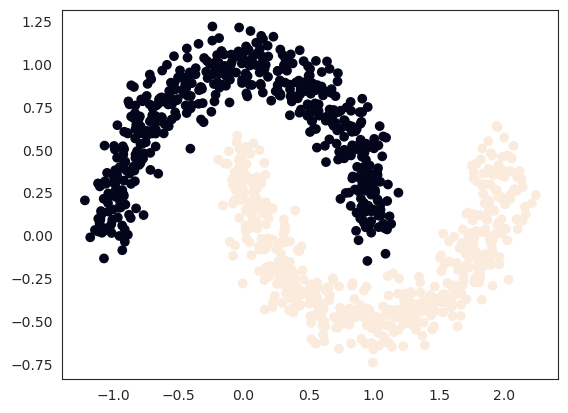

In [29]:
X, y = make_moons(n_samples=1000, noise=0.1)

plt.scatter(X[:,0], X[:,1], c=y)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
class MLP(nn.Module):
    def __init__(self, dims):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                # add act except for the last layer
                self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [31]:
# Training loop
def train_loop(model, optimizer, epochs=5000, regularization=None):
    criterion = nn.CrossEntropyLoss()
    for epoch in (pbar:=tqdm.trange(epochs)):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        if regularization:
            loss += regularization(model, swap=epoch%(epochs//100)==0)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.4f}")
        if epoch % (epochs // 5) == 0:
            with torch.no_grad():
                y_pred = model(X_test)
                loss = criterion(y_pred, y_test)
            print(f"Test Loss: {loss.item():.4f}")

In [32]:
def plot_mlp(model, title=""):
    # visualize the model as neurons and their connections
    height = 0
    first_layer = True
    centered_range = lambda x: np.arange(x) - (x - 1) / 2

    # max bias used for scaling neurons
    max_bias = max([layer.bias.abs().max().item() for layer in model.layers if isinstance(layer, nn.Linear)])
    scaler = lambda biases: (biases.abs().cpu().detach().numpy() / max_bias) 
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            # plot neurons
            height += 1
            width = layer.weight.shape[0]
            prev_width = layer.weight.shape[1]
            if first_layer:
                first_layer = False
                plt.scatter(centered_range(prev_width), np.zeros(prev_width) + height - 1, c="black", s=10)
            color = "C0" if layer.bias[0].item() < 0 else "C1"
            alpha = [max(0.1, a) for a in scaler(layer.bias)]
            plt.scatter(centered_range(width), np.zeros(width) + height, c=color, s=10, alpha=alpha)
            # plot connections
            max_weight = layer.weight.abs().max().item()
            alphas = layer.weight.abs().detach().numpy() / max_weight
            for i, x in enumerate(centered_range(width)):
                for j, y in enumerate(centered_range(prev_width)):
                    color = "C0" if layer.weight[i, j].item() < 0 else "C1"
                    alpha = alphas[i, j]
                    plt.plot([x, y], [height, height-1], c=color, alpha=alpha)
    plt.axis("off")
    plt.title(title)
    plt.show()


Loss: 0.0767:   0%|          | 0/5000 [00:00<?, ?it/s]

Loss: 0.0034:   2%|▎         | 125/5000 [00:00<00:07, 628.64it/s]

Test Loss: 0.6963


Loss: 0.0000:  22%|██▏       | 1118/5000 [00:01<00:05, 747.10it/s]

Test Loss: 0.0000


Loss: 0.0000:  43%|████▎     | 2157/5000 [00:02<00:03, 816.52it/s]

Test Loss: 0.0000


Loss: 0.0000:  63%|██████▎   | 3155/5000 [00:04<00:02, 830.04it/s]

Test Loss: 0.0000


Loss: 0.0000:  83%|████████▎ | 4168/5000 [00:05<00:00, 837.99it/s]

Test Loss: 0.0000


Loss: 0.0000: 100%|██████████| 5000/5000 [00:06<00:00, 792.02it/s]


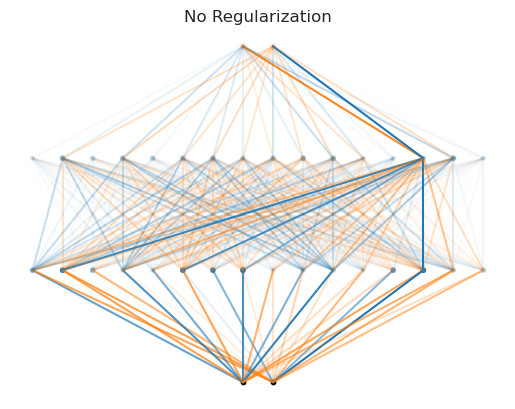

In [33]:
model = MLP([2, 16, 16, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loop(model, optimizer)
plot_mlp(model, "No Regularization")

Loss: 0.0081:   2%|▎         | 125/5000 [00:00<00:07, 628.87it/s]

Test Loss: 0.6811


Loss: 0.0010:  22%|██▏       | 1094/5000 [00:01<00:05, 771.18it/s]

Test Loss: 0.0006


Loss: 0.0005:  43%|████▎     | 2144/5000 [00:02<00:03, 773.41it/s]

Test Loss: 0.0004


Loss: 0.0003:  63%|██████▎   | 3143/5000 [00:04<00:02, 754.65it/s]

Test Loss: 0.0002


Loss: 0.0001:  83%|████████▎ | 4162/5000 [00:05<00:01, 790.40it/s]

Test Loss: 0.0001


Loss: 0.0001: 100%|██████████| 5000/5000 [00:06<00:00, 761.31it/s]


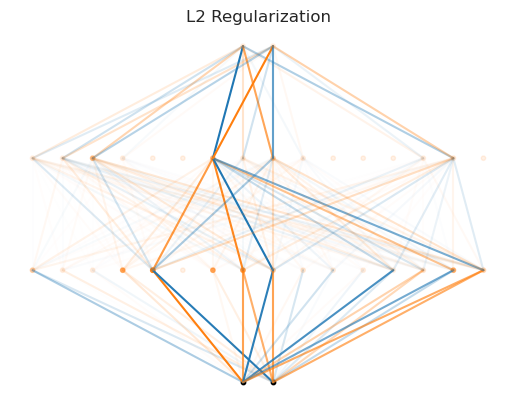

In [34]:
title = "L2 Regularization"
model = MLP([2, 16, 16, 2])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.1)

train_loop(model, optimizer)
plot_mlp(model, title)

Loss: 0.1216:   1%|▏         | 69/5000 [00:00<00:07, 686.10it/s]

Loss: 0.0716:   3%|▎         | 140/5000 [00:00<00:06, 697.94it/s]

Test Loss: 0.6561


Loss: 0.0284:  23%|██▎       | 1130/5000 [00:01<00:05, 695.44it/s]

Test Loss: 0.0018


Loss: 0.0251:  43%|████▎     | 2132/5000 [00:03<00:04, 710.97it/s]

Test Loss: 0.0014


Loss: 0.0242:  62%|██████▏   | 3096/5000 [00:04<00:02, 654.28it/s]

Test Loss: 0.0013


Loss: 0.0242:  82%|████████▏ | 4105/5000 [00:06<00:01, 677.64it/s]

Test Loss: 0.0011


Loss: 0.0242: 100%|██████████| 5000/5000 [00:07<00:00, 659.32it/s]


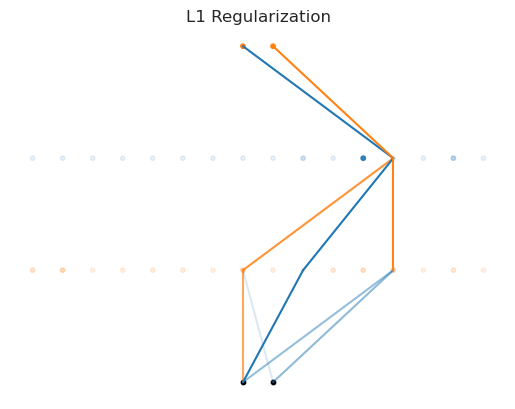

In [35]:
title = "L1 Regularization"
torch.manual_seed(42)
model = MLP([2, 16, 16, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loop(model, optimizer, regularization=l1_reg)
plot_mlp(model, title)

Loss: 0.1739:   1%|          | 124/20000 [00:00<00:32, 613.64it/s]

Test Loss: 0.6581


Loss: 0.0518:  20%|██        | 4088/20000 [00:07<00:25, 617.03it/s]

Test Loss: 0.0030


Loss: 0.0512:  41%|████      | 8101/20000 [00:14<00:22, 519.90it/s]

Test Loss: 0.0027


Loss: 0.0512:  60%|██████    | 12042/20000 [00:22<00:16, 470.68it/s]

Test Loss: 0.0028


Loss: 0.0512:  80%|████████  | 16081/20000 [00:29<00:07, 490.46it/s]

Test Loss: 0.0028


Loss: 0.0511: 100%|██████████| 20000/20000 [00:37<00:00, 539.12it/s]


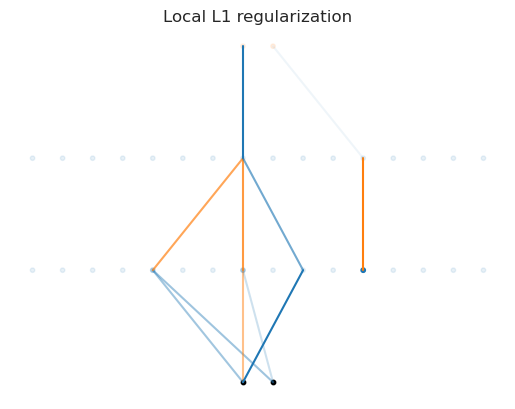

In [46]:
title = "Local L1 regularization"
torch.manual_seed(42)

model = MLP([2, 16, 16, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loop(model, optimizer, regularization=partial(local_reg, regularize_bias=True))
plot_mlp(model, title)

Loss: 0.2171:   1%|          | 105/20000 [00:00<00:37, 536.06it/s]

Test Loss: 0.6581


Loss: 0.0555:  20%|██        | 4090/20000 [00:08<00:31, 501.13it/s]

Test Loss: 0.0530


Loss: 0.0510:  41%|████      | 8105/20000 [00:16<00:22, 530.88it/s]

Test Loss: 0.0575


Loss: 0.0510:  60%|██████    | 12056/20000 [00:24<00:16, 488.54it/s]

Test Loss: 0.0565


Loss: 0.0509:  80%|████████  | 16066/20000 [00:33<00:08, 470.19it/s]

Test Loss: 0.0580


Loss: 0.0506: 100%|██████████| 20000/20000 [00:41<00:00, 485.97it/s]


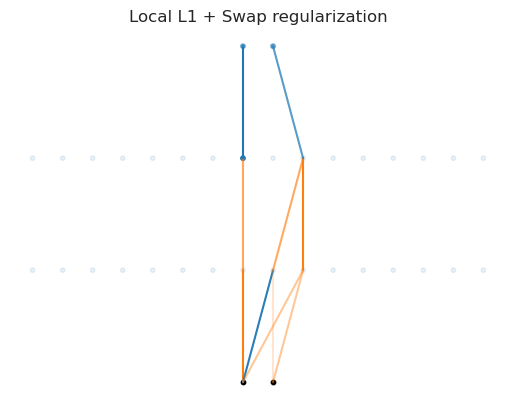

In [47]:
title = "Local L1 + Swap regularization"
torch.manual_seed(42)


model = MLP([2, 16, 16, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loop(
    model,
    optimizer,
    regularization=partial(
        bimt_reg, topk=5, entropy_threshold=0.6, regularize_bias=True
    ),
)

plot_mlp(model, title)